# References:

https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet

https://medium.com/@nutanbhogendrasharma/how-to-collect-data-using-twitter-api-v2-for-natural-language-processing-35f798e998fa

https://github.com/twitterdev/getting-started-with-the-twitter-api-v2-for-academic-research/blob/main/modules/5-how-to-write-search-queries.md

https://towardsdatascience.com/social-media-sentiment-analysis-49b395771197



# 1. Extract Nike and Addidas Data from Twitter

## 1.1 Export neccessay library

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

import tweepy
from textblob import TextBlob


import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer , WordNetLemmatizer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import requests
import re
import string

## 1.2 Connect to Twitter API function

In [2]:
def dev_account():
    bearer_token = '*******'
    consumer_key = '********' # API Key
    consumer_secret = '*********' # API Key Secret

    access_token = '*********'
    access_token_secret = '**********'

    client = tweepy.Client(bearer_token, consumer_key, consumer_secret, access_token, access_token_secret, wait_on_rate_limit=True)
    return client

In [3]:
def extract_data(response):
    user_name, followers_count, likes, retweets, reply, impression, text = [], [], [], [], [], [], []

    for tweet in response:
        Id = tweet.author_id    
        user_name.append(client.get_user(id=Id).data.name)
        followers_count.append(client.get_user(id=Id, user_fields = ['public_metrics']).data.public_metrics['followers_count'])

        likes.append(tweet.public_metrics['like_count'])
        retweets.append(tweet.public_metrics['retweet_count'])
        reply.append(tweet.public_metrics['reply_count'])
        impression.append(tweet.public_metrics['impression_count'])
        text.append(tweet.text)         

    df = pd.DataFrame(list(zip(user_name, followers_count, likes, retweets, reply, impression, text)), columns =['User_Name', 'followers_Count', 'Likes', 'Retweets', 'Reply', 'Impression', 'Text'])
    return df    

## 1.3 Getting Data

In [4]:
client = dev_account()

query = "adidas lang:en is:verified -is:retweet -is:reply -is:quote"

response = tweepy.Paginator(client.search_recent_tweets, 
                            query=query,
                            tweet_fields=['created_at', 'public_metrics'],
                            expansions = ['author_id'],
                            max_results=100).flatten(limit=1000)

adidas = extract_data(response)
adidas['Label'] = 'Adidas'

Rate limit exceeded. Sleeping for 843 seconds.
Rate limit exceeded. Sleeping for 841 seconds.
Rate limit exceeded. Sleeping for 841 seconds.


In [ ]:
#df.to_csv('adidas.csv', index=False)

In [5]:
client = dev_account()

query = "adidas lang:en is:verified -is:retweet -is:reply -is:quote"

response = tweepy.Paginator(client.search_recent_tweets, 
                            query=query,
                            tweet_fields=['created_at', 'public_metrics'],
                            expansions = ['author_id'],
                            max_results=100).flatten(limit=1000)

nike = extract_data(response)
nike['Label'] = 'Nike'

Rate limit exceeded. Sleeping for 840 seconds.
Rate limit exceeded. Sleeping for 843 seconds.
Rate limit exceeded. Sleeping for 841 seconds.
Rate limit exceeded. Sleeping for 842 seconds.


In [ ]:
#df.to_csv('nike.csv', index=False)

In [8]:
df = pd.concat([adidas, nike])

## 1.4 Extract Hastag

In [7]:
def extract_hashtags(df):
    hashtags = df['Text'].str.extractall(r'#(\w+)').reset_index()
    hashtags.columns = ['index', 'match', 'hashtags']
    hashtags = pd.pivot_table(hashtags, index = 'index', values='hashtags', aggfunc=lambda x: ' '.join(x))
    df = pd.merge(df, hashtags, how='left', left_index=True, right_index=True)
    return df

In [12]:
df = extract_hashtags(df)

In [11]:
df.to_csv('data.csv', index= False)

# 2. Text Cleaning

## 2.1 Remove Redundant Text

In [3]:
def clean(text):
    text = re.sub("https*\S+", "", text) #remove URL
    text = re.sub("@\S+", "", text) #remove mentions
    text = re.sub("#\S+", "", text) #remove hashtags
    text = text.encode('ascii', 'ignore').decode() # Remove unicode characters
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Remove punctuation
    text = re.sub('\w*\d+\w*', '', text) #remove number
    return text

In [4]:
df['Text1'] = df['Text'].apply(clean)


## 2.2 Remove Stopwords

In [5]:
def removestopwords(text):
    # Convert text to lowercase and split to a list of words
    tokens = word_tokenize(text.lower())
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    token = [t for t in tokens if t not in stop_words]
    return(" ".join(token))

In [6]:
df['Text1'] = df['Text1'].apply(removestopwords)

## 2.3 Stemming and Lemmatization

In [7]:
#nltk.download('wordnet')
def Lemmatization(text):
    wn = WordNetLemmatizer()
    w = [wn.lemmatize(word) for word in text.split(' ')]
    return(" ".join(w))

def Porterstemmer(text):
    ps = PorterStemmer()
    w = [ps.stem(word) for word in text.split(' ')]
    return(" ".join(w))

def Snowballstemmer(text):
    ss = SnowballStemmer(language = 'english')
    w = [ss.stem(word) for word in text.split(' ')]
    return(" ".join(w))


In [9]:
df['Lemma'] = df['Text1'].apply(Lemmatization)
df['Porterstemmer'] = df['Text1'].apply(Porterstemmer)
df['Snowballstemmer'] = df['Text1'].apply(Snowballstemmer)


In [10]:
df = df.drop('Text1', axis=1)

In [11]:
df= df.drop_duplicates(subset=['Text','User_Name'])

In [6]:
df = pd.read_csv('Final_data.csv')

# 3. EDA and Visualisation

## 3.1 Text Visualisation

In [3]:
#All of the stats are left-skewed
df[['followers_Count','Likes'	, 'Retweets',	'Reply',	'Impression']].describe()

,followers_Count,Likes,Retweets,Reply,Impression
count,4.355000e+03,4355.000000,4355.000000,4355.000000,4.355000e+03
mean,6.616520e+05,148.819518,14.859242,4.363490,2.765877e+04
std,2.454094e+06,1900.258197,181.109376,33.229528,1.719371e+05
min,1.670000e+02,0.000000,0.000000,0.000000,0.000000e+00
25%,4.699150e+04,2.000000,0.000000,0.000000,1.836500e+03
50%,2.686050e+05,8.000000,1.000000,0.000000,1.022600e+04
75%,4.738460e+05,23.000000,3.000000,1.000000,2.080250e+04
max,6.127169e+07,77881.000000,8401.000000,1176.000000,5.982544e+06


In [4]:
df_outlierdrop = df[(np.abs(stats.zscore(df[['followers_Count','Likes'	, 'Retweets',	'Reply',	'Impression']])) < 0.5).all(axis=1)]

<Axes: xlabel='Impression', ylabel='Count'>

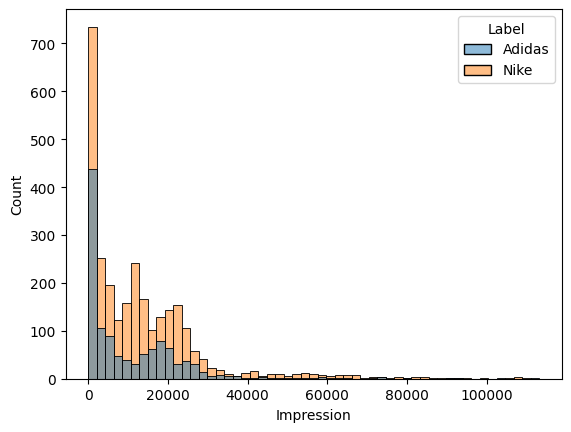

In [5]:
#Impression Distribution
sns.histplot (data = df_outlierdrop, x = 'Impression', hue = 'Label')

<Axes: xlabel='Label', ylabel='count'>

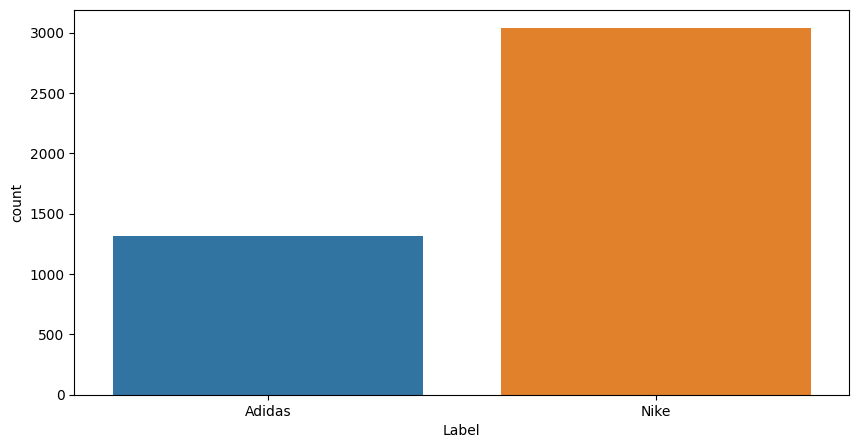

In [6]:
plt.figure(figsize=(10, 5))

sns.countplot(df, x = "Label")

In [7]:
adidas = df[df['Label'] == 'Adidas']
nike = df[df['Label'] == 'Nike']

In [2]:
def wordcloud(wc1, wc2):
    fig = plt.figure(figsize=(20, 30))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(wc1.recolor(color_func=image_colors), interpolation="hamming")
    plt.title('Adidas', fontsize = 36)
    plt.axis('off')

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(wc2.recolor(color_func=image_colors), interpolation="hamming")
    plt.title('Nike', fontsize = 36)
    plt.axis('off')
    
    plt.show()

In [9]:
#bar chart top 10 words in verbatim
def top_10_words(all_words):
    words = all_words.split(' ')
    counts = Counter(words)
    counts = dict(sorted(counts.items(), key=lambda x:x[1], reverse=True))
    top_10 = {k: counts[k] for k in list(counts)[:10]}
    
    return top_10

In [10]:
def barchart_top(top1, top2):
    fig = plt.figure(figsize=(20, 5))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.bar(*zip(*top1.items()), color='blue')
    plt.title('Adidas', fontsize = 36)
    plt.ylim((0, 2500))

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.bar(*zip(*top2.items()), color='orange')
    plt.title('Nike', fontsize = 36)
    plt.ylim((0, 2500))
    
    plt.show()

In [11]:
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))
image_colors = ImageColorGenerator(Mask)

In [9]:
all_words_adidas = ' '.join(str(w) for w in adidas['Lemma'])
all_words_nike = ' '.join(str(w) for w in nike['Lemma'])

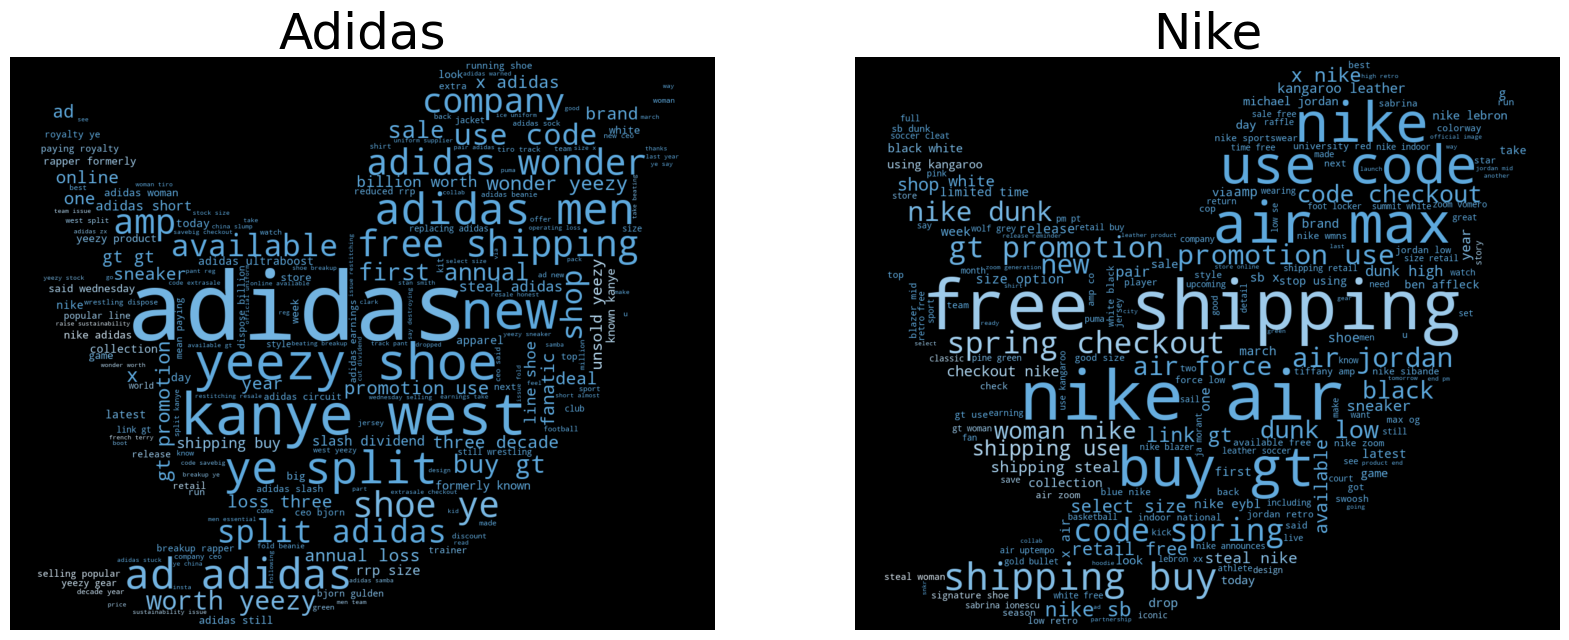

In [10]:
wc_adidas = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_adidas)
wc_nike = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_nike)

wordcloud(wc_adidas, wc_nike)

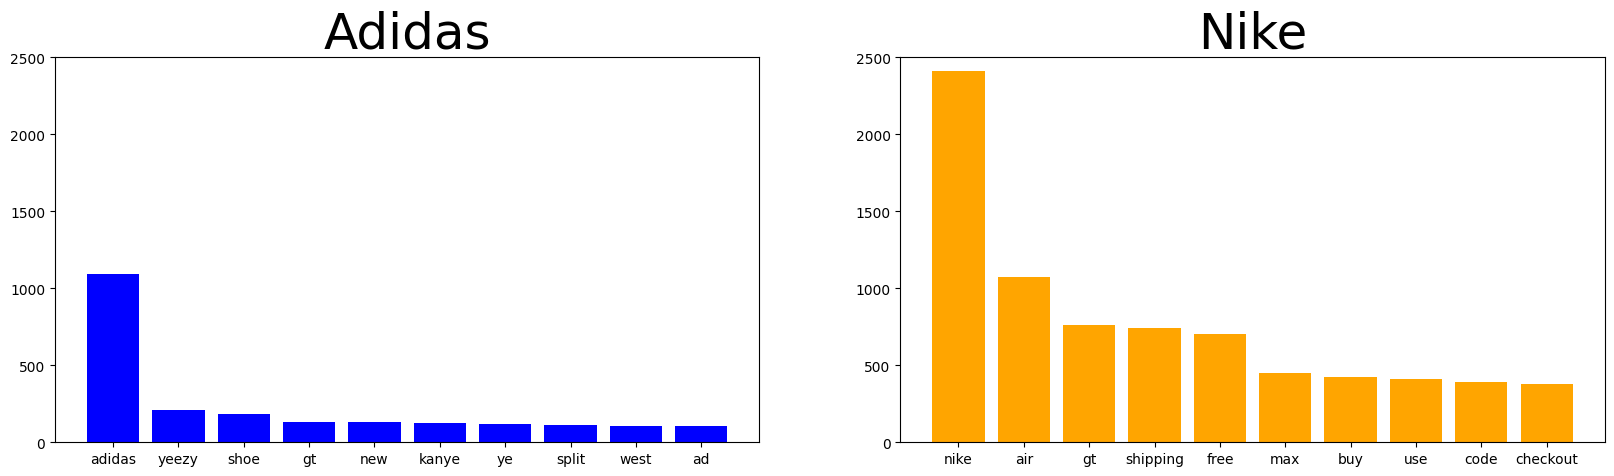

In [10]:
top_adidas = top_10_words(all_words_adidas)
top_nike = top_10_words(all_words_nike)

barchart_top(top_adidas, top_nike)

## 3.2 Hastag Visualisation

In [11]:
hashtags = ' '.join(str(w).lower() for w in df['hashtags'].dropna())

all_hashtags = hashtags.split(' ')
all_hashtags = Counter(all_hashtags)
all_hashtags = dict(sorted(all_hashtags.items(), key=lambda x:x[1], reverse=True))


#top = {k: all_hashtags[k] for k in list(all_hashtags) if all_hashtags[k]>3}
top = {k: all_hashtags[k] for k in list(all_hashtags)[:10]}

In [12]:
top.keys()

dict_keys(['promotion', 'nike', 'welcometothecircuit', 'adidas', 'eybl', 'airmax', 'pitt', 'sneakers', 'footpatrol', 'teamfp'])

In [13]:
top_df = pd.DataFrame({'Category': top.keys(), 'count': top.values()})


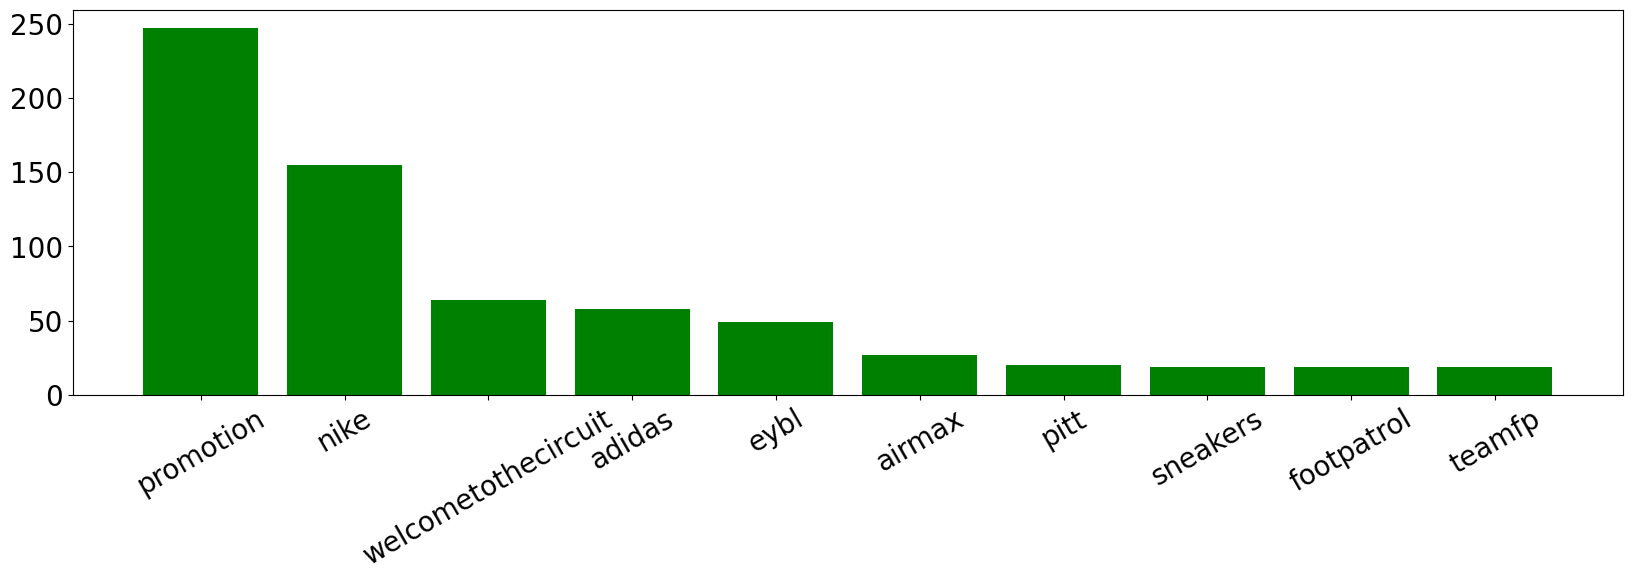

In [14]:
#plotly - hover
plt.figure(figsize=(20, 5))
plt.bar(*zip(*top.items()), color='green')

plt.tick_params(labelsize=20)
plt.xticks(rotation=30)

plt.show()

# 4. Sentiment Analysis


## 4.1 Calculate Polarity and Subjectivity Score

In [7]:
roi = df.Snowballstemmer

In [8]:
blobs = []
for tweet in roi.values:
    #print(tweet)
    try:
        blob = TextBlob(tweet)
        blobs.append(blob)
    except:
        blobs.append(None)

In [9]:
polarity_scores = []
subjectivity_scores = []
sentiment = []
for obj in blobs:
    try:
        score  = obj.sentiment
        polarity_scores.append(score[0])
        subjectivity_scores.append(score[1])
        if score[0] > 0.1: #threshold
            sentiment.append('Positive')
        elif score[0] < -0.1:
            sentiment.append('Negative')
        else:
            sentiment.append('Neutral')
    except:
        polarity_scores.append(None)
        subjectivity_scores.append(None)
        sentiment.append(None)



In [10]:
df['polarity_scores'] = polarity_scores
df['subjectivity_scores'] = subjectivity_scores
df['sentiment'] = sentiment

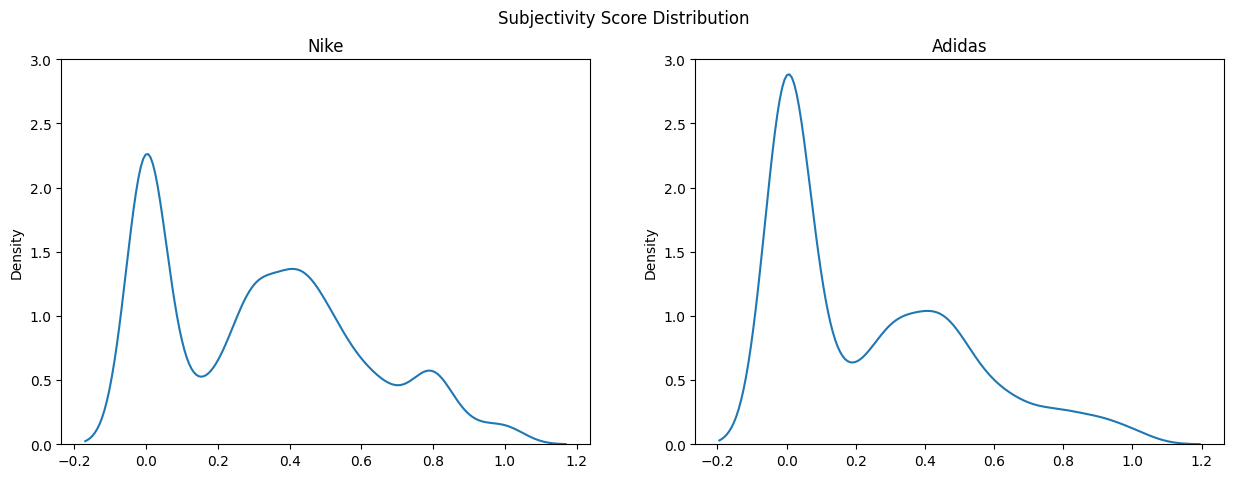

In [11]:
fig, axes = plt.subplots(1,2, figsize =  (15,5))
sns.kdeplot(df[df['Label'] == "Nike"], x='subjectivity_scores',  ax = axes[0])
sns.kdeplot(df[df['Label'] == "Adidas"], x='subjectivity_scores',  ax = axes[1])
fig.suptitle('Subjectivity Score Distribution')

axes[0].set_title('Nike')
axes[0].set_xlabel('')
axes[0].set_ylim((0,3))
axes[1].set_title('Adidas')
axes[1].set_xlabel('')
axes[1].set_ylim((0,3))

plt.show()

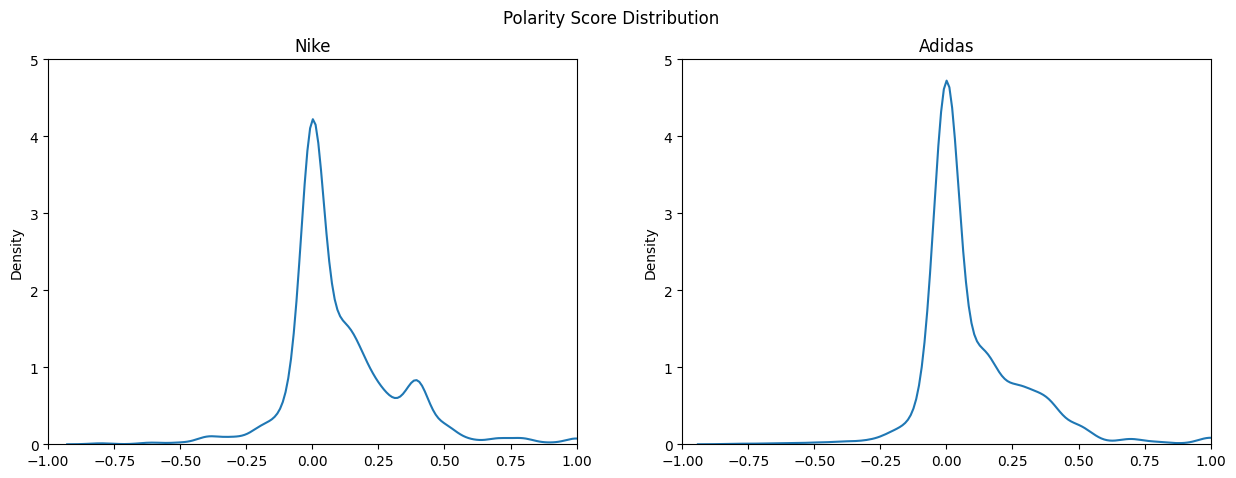

In [12]:
fig, axes = plt.subplots(1,2, figsize =  (15,5))
sns.kdeplot(df[df['Label'] == "Nike"], x='polarity_scores', ax = axes[0])
sns.kdeplot(df[df['Label'] == "Adidas"], x='polarity_scores',  ax = axes[1])
fig.suptitle('Polarity Score Distribution')

axes[0].set_title('Nike')
axes[0].set_xlabel('')
axes[0].set_ylim((0,5))
axes[0].set_xlim((-1,1))
axes[1].set_title('Adidas')
axes[1].set_xlabel('')
axes[1].set_ylim((0,5))
axes[1].set_xlim((-1,1))

plt.show()

In [55]:
count_table = df.groupby(['Label']).agg(({'sentiment': 'value_counts'}))
state_pcts = count_table.groupby(level=0, group_keys=False).apply(lambda x:
                                                 100 * x / float(x.sum())).rename(columns={'sentiment':'Percentage'}).reset_index()


In [56]:
state_pcts

,Label,sentiment,Percentage
0,Adidas,Neutral,62.642369
1,Adidas,Positive,33.485194
2,Adidas,Negative,3.872437
3,Nike,Neutral,55.749588
4,Nike,Positive,38.550247
5,Nike,Negative,5.700165


<Axes: xlabel='sentiment', ylabel='Percentage'>

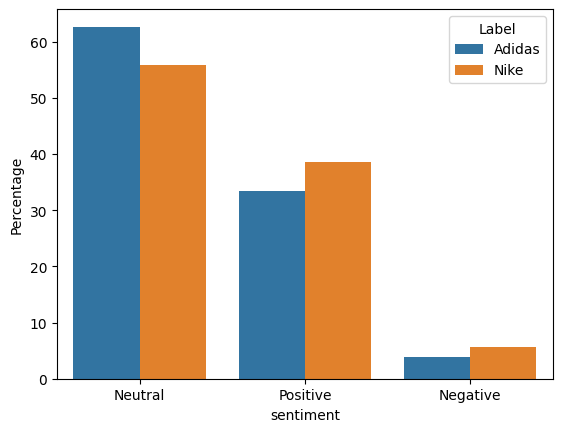

In [58]:
sns.barplot(state_pcts, x = 'sentiment', y = 'Percentage', hue = 'Label')

## 4.2 TextBlob Polarity Model Explainability

In [34]:
#redefine textBlob model to extract Polarity
def textBlob_model(X):
    results = []
    for i in range(len(X)):
        res = TextBlob(X[i]).polarity
        results.append(res)
    return results

In [35]:
#Tokenize the text
import shap
masker = shap.maskers.Text() 
explainer = shap.Explainer(textBlob_model, masker=masker)


c:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [36]:
## only retrive text having more than 1 word
text_explain = []
for i in df.Snowballstemmer.values:
    try:
        if len(i.split())>1:
            text_explain.append(i)
    except:
        pass

In [37]:
#global explain
shap_values = explainer(text_explain)

Partition explainer: 4342it [05:55, 12.01it/s]                          


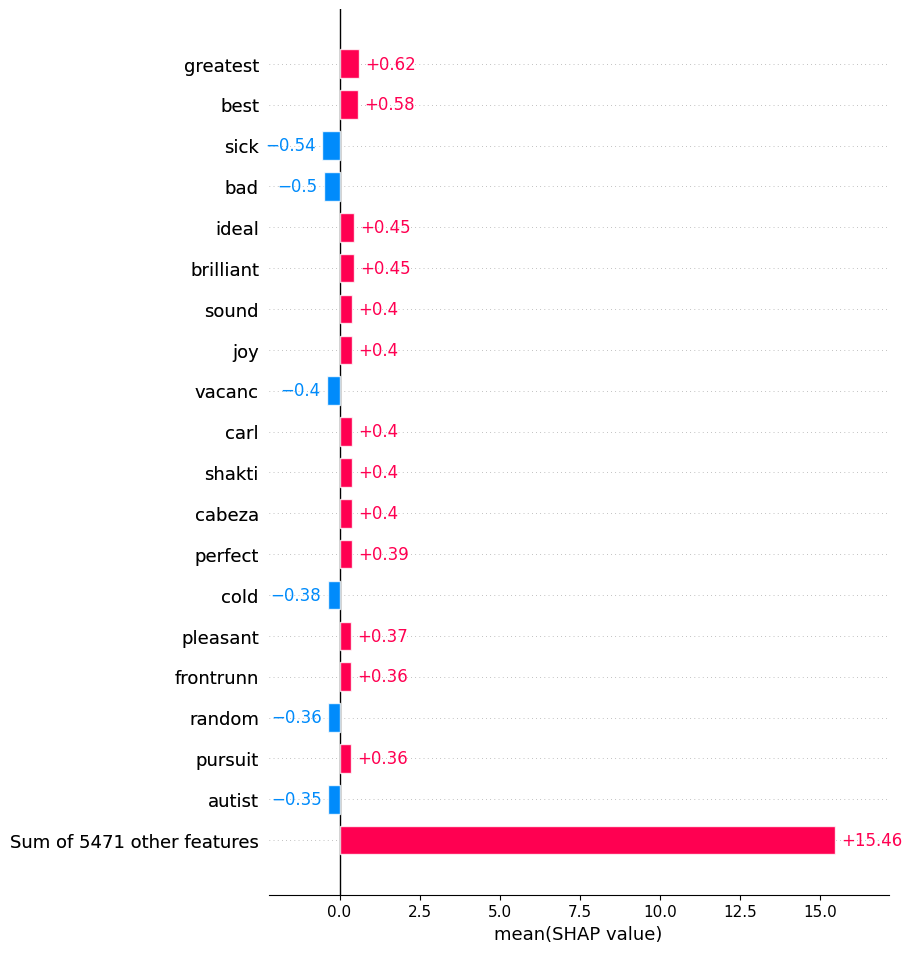

In [38]:
shap.plots.bar(shap_values.mean(0),max_display=20)

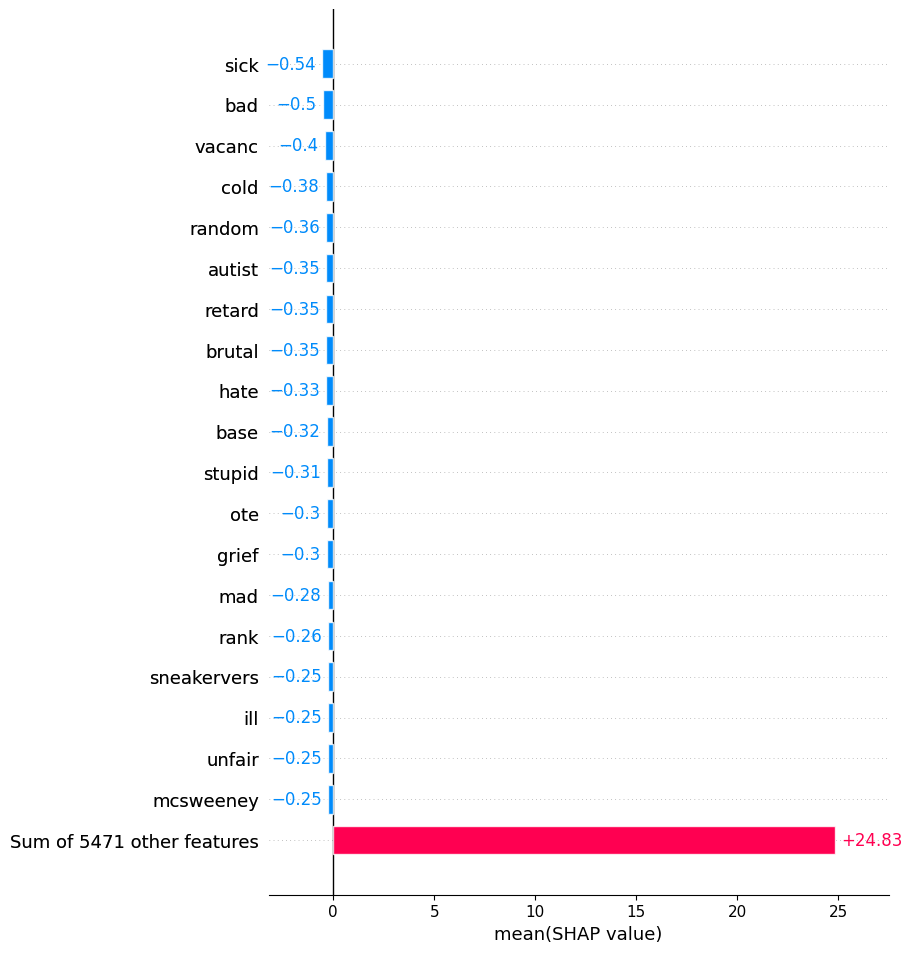

In [39]:
# fig, axes = plt.subplots(1,2, figsize =  (10,10))
# axes[0,0] = shap.plots.bar(shap_values.mean(0),max_display=20, order=shap.Explanation.argsort)
shap.plots.bar(shap_values.mean(0),max_display=20, order=shap.Explanation.argsort)

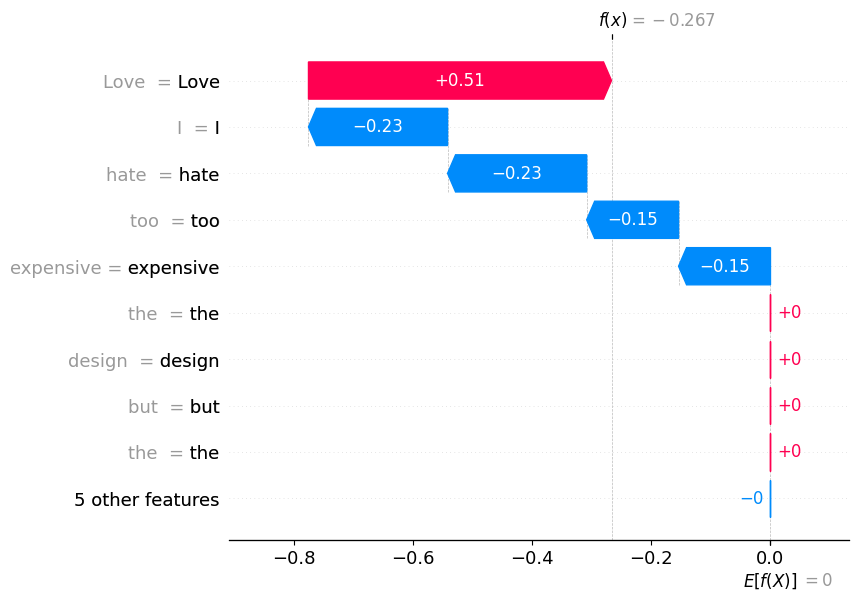

In [40]:
#Local explainer
text_ = "Love the design but I hate the fact that the price is too expensive" # ==> stemmer and lemma
shap_individual = explainer([text_])
shap.plots.waterfall(shap_individual[0])

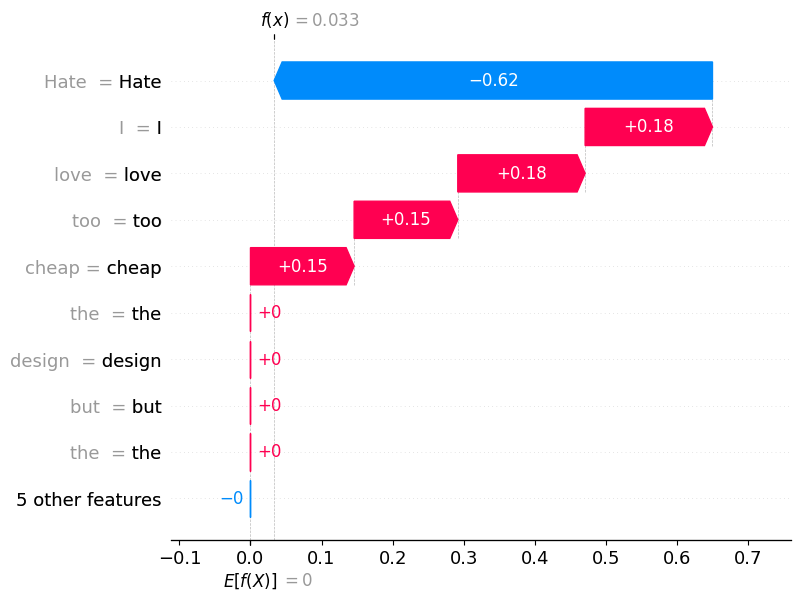

In [41]:
#Local explainer
text_ = "Hate the design but I love the fact that the price is too cheap" 
shap_individual = explainer([text_])
shap.plots.waterfall(shap_individual[0])

# 5. Conclusion

- Comparing between Nike and Addidas:
    + For most recent 14 days, people express their ideas about Nike more than Addidas
    + The polarity and subjectivity sentiment between verbatims in Nike and Addidas is somewhat the same
    + Disclosing the hastag and verbatim, people mainly talk about the promotion, shipping and different categories of shoes in the two brands
- TextBlob works better when text is clean. However, other models should be studied to better do the sentiment analysis
- We can generalise the idea to do the sentiment analysis for general apparel brands 